# Bevan Joubert

## Project 8 - Natural Language Processing

In [1]:
# Import the required packages.
# Standard Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
# Text preprocessing.
import re
from bs4 import BeautifulSoup
import spacy
nlp = spacy.load('en_core_web_sm')
import contractions
import unicodedata
import emoji
import wordninja # see https://github.com/keredson/wordninja
# Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Tenserflow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
# Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Do some formatting of the page.
from IPython.core.interactiveshell import InteractiveShell
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:0.4f}'.format)

In [3]:
# If running locally with GPU. Do this to prevent errors due to GPU memory limit.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 1. Import the Data

In [4]:
# Import the dataset.
tweets = pd.read_csv("tweets.csv")

In [5]:
# View the shape of the dataset.
tweets.shape

(14640, 15)

In [6]:
# View information about each column.
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [7]:
# See how many airlines are involved.
tweets['airline'].nunique()

6

In [8]:
# See which airlines these are.
for airline in (tweets['airline'].unique()):
    print(airline)

Virgin America
United
Southwest
Delta
US Airways
American


In [9]:
# See how many different sentiments there are.
tweets['airline_sentiment'].nunique()

3

In [10]:
# See what these sentiments are.
for sentiment in (tweets['airline_sentiment'].unique()):
    print(sentiment)

neutral
positive
negative


In [11]:
# Display the first 5 entries of the dataset.
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,nan,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,nan,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### 2. Understanding Data Columns

#### 2a. Drop Columns from Dataframe

In [12]:
# Get the list of columns currently in the dataframe.
columns = list(tweets.columns)

In [13]:
# We only need the text and airline_sentiment columns.
# Make a list containing the columns that need to be dropped.
dropColumns = columns
dropColumns.remove('text')
dropColumns.remove('airline_sentiment')
dropColumns

['tweet_id',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [14]:
# Drop these columns from the dataframe.
textSentiments = tweets.drop(dropColumns, axis='columns')

#### 2b. Check the Shape of the Data

In [15]:
# Show the shape of the new dataframe.
textSentiments.shape

(14640, 2)

#### 2c. Print the First 5 Rows of Data

In [16]:
# Show the first 5 rows of the new dataframe.
textSentiments.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


### 3. Text Preprocessing

In [17]:
# Create some useful functions before starting the text preprocessing.

# Create a function to find entries which contain certain text patterns.
def findPattern(pattern, textList):
    '''
    Finds the indices of "textList" where "pattern" occurs.
    Returns these indices as a list.
    pattern -> A pattern to find. Can be passes as raw text or a precompiled pattern.
    textList -> A list containing text entries.
    '''
    if(type(pattern) != re.Pattern):
        pattern = re.compile(pattern)
    
    indices = [] # A list containing the indices where the pattern exists.
    for i, text in enumerate(textList):
        if pattern.search(textList[i]) != None:
            indices.append(i)
    
    return indices

# Create a function to remove patterns from text entries.
def removePattern(pattern, textList):
    '''
    Removes the pattern from the passed text.
    pattern -> The pattern to remove.
    textList -> A list containing the text from which the pattern must be removed.
    Returns a new list of text entries with the pattern removed.
    '''
    newList = []
    
    if(type(pattern) != re.Pattern):
        pattern = re.compile(pattern)
    
    for text in textList:
        newList.append(pattern.sub('', text))
    
    return newList

# Create a function to replace patterns with a custom text string.
def replacePattern(pattern, replaceString, textList):
    '''
    Removes the pattern from the passed text.
    pattern -> The pattern to remove.
    textList -> A list containing the text from which the pattern must be removed.
    Returns a new list of text entries with the pattern removed.
    '''
    newList = []
    
    if(type(pattern) != re.Pattern):
        pattern = re.compile(pattern)
    
    for text in textList:
        newList.append(pattern.sub(replaceString, text))
    
    return newList

# Create function to remove leading and lagging white space and to replace all white space with as single space.
def stripAndSpace(textList):
    newList = []
    pattern = re.compile(r'(\s+)')
    for text in textList:
        newList.append(pattern.sub(' ', text.strip()))
    
    return newList


In [18]:
# Create some common patterns to search for.
pattern_htmlTags = re.compile(r'<[^<]+?>')
pattern_url = re.compile(r'https?://[^\s]*')
pattern_twitterHandle = re.compile(r'@[^\s]*')
pattern_specialChars = re.compile(r'[^a-zA-z0-9\s]+')
pattern_specialCharsNoHash = re.compile(r'[^a-zA-z0-9\s#]+')
pattern_specialCharsAndDigits = re.compile(r'[^a-zA-z\s]+')
pattern_digitChars = re.compile(r'[0-9]+')
pattern_whitespace = re.compile(r'(\s+)')
pattern_singleChar = re.compile(r'\b[^\s]\b')
pattern_upToTwoChars = re.compile(r'\b[^\s]{1,2}\b')
pattern_upToThreeChars = re.compile(r'\b[^\s]{1,3}\b')
pattern_hashTag = re.compile(r'#\w+')

In [19]:
seed=1

In [20]:
# Create a list on which all the preprocessing will be done.
textData = textSentiments['text']
textData[0:5]

0                                                                                               @VirginAmerica What @dhepburn said.
1                                                          @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                           @VirginAmerica I didn't today... Must mean I need to take another trip!
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                           @VirginAmerica and it's a really big bad thing about it
Name: text, dtype: object

#### 3a. HTML Tag Removal

In [21]:
# Create a function to reomove the HTML tags from the text.
def removeHtml(textList):
    ''' 
    Removes HMTL tags from a list of text entries using the BeuatifulSoup html parser.
    textList -> A list containing the text from which the pattern must be removed.
    '''
    # Create a new list which will be returned with html tags removed.
    newList = []
    # Parse each entry in the textList through a BeautifulSoup html parser.
    for text in textList:
        htmlParser = BeautifulSoup(text, "html.parser")
        newList.append(htmlParser.get_text())
    # Return the ne list.
    return newList

In [22]:
# Remove the HTML tags with the newly defined function.
textData = removeHtml(textData)

In [23]:
random.seed(seed)
random.sample(textData, 10)

["@united it's been over 3 hours...at what point do you let people off of the plane? @FoxNews @CNN @msnbc",
 '@USAirways THANK YOU for resolving the issue. On direct flight to sfo from @united',
 '@AmericanAir Great - thank you.',
 '@AmericanAir how can I when system always hangs up on me?',
 '@AmericanAir terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 '@united Ok thank again for your help!',
 "@united I travel a lot and I get it. You're still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.",
 '@united thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 '@JetBlue no. Did not catch his name. I am sure Jason will know.',
 '@AmericanAir machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

#### Additional Text Processing

In [24]:
# Before continuing with the prescribed processing, I would like to perform additional text processing.
# The order of these functions is quite important, different oredering might remove more information than required.

In [25]:
# Replace all contractions with their expanded formats.
# Define a function to perform this action on a list of text entries.
def expandContractions(textList):
    ''' 
    Replaces contracted words with their expanded form, example: can't = can not.
    textList -> A list containing the text entries for which the contractions must be expanded.
    '''
    # Create the return list.
    newList = []
    # Expand the contractions for each text entry using the contractions library.
    for text in textList:
        newList.append(contractions.fix(text))
    # Return the newly created text list.
    return newList

In [26]:
# Call the newly created function to expand the contractions.
textData = expandContractions(textData)

In [27]:
random.seed(seed)
random.sample(textData, 10)

['@united it is been over 3 hours...at what point do you let people off of the plane? @FoxNews @CNN @msnbc',
 '@USAirways THANK YOU for resolving the issue. On direct flight to sfo from @united',
 '@AmericanAir Great - thank you.',
 '@AmericanAir how can I when system always hangs up on me?',
 '@AmericanAir terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 '@united Ok thank again for your help!',
 '@united I travel a lot and I get it. you are still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.',
 '@united thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 '@JetBlue no. Did not catch his name. I am sure Jason will know.',
 '@AmericanAir machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

In [28]:
# Replace any form of ellipses with a space, these are strings of dots, such as '...'.
# These can be seen as token bonderies and therfore a space is a fitting replacement.
# Only reqplace the dots if there is more than one following each other.
def dotsToSpace(textList):
    ''' 
    Replaces any occurrence of more than once consecutive dot with a space.
    A space is important because dots are obviously word boundaries and spaces are easily removed.
    textList -> A list containing the text from which the pattern must be removed.
    '''
    # Create the return list.
    newList = []
    # Create the pattern to replace.
    pattern = re.compile(r'(\.\.+)')
    # Replace any occurences of the pattern in the text entries.
    for text in textList:
        newList.append(pattern.sub(' ', text))
    # Return the ne list of text entries.
    return newList

In [29]:
# Call the newly created function.
textData = dotsToSpace(textData)

In [30]:
random.seed(seed)
random.sample(textData, 10)

['@united it is been over 3 hours at what point do you let people off of the plane? @FoxNews @CNN @msnbc',
 '@USAirways THANK YOU for resolving the issue. On direct flight to sfo from @united',
 '@AmericanAir Great - thank you.',
 '@AmericanAir how can I when system always hangs up on me?',
 '@AmericanAir terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 '@united Ok thank again for your help!',
 '@united I travel a lot and I get it. you are still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.',
 '@united thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 '@JetBlue no. Did not catch his name. I am sure Jason will know.',
 '@AmericanAir machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

In [31]:
# Remove twitter handles, as these add no sentiment information.
# Call the already created 'removePattern' function with the already created pattern 'pattern_twitterHandle'.
textData = removePattern(pattern_twitterHandle, textData)

In [32]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over 3 hours at what point do you let people off of the plane?   ',
 ' THANK YOU for resolving the issue. On direct flight to sfo from ',
 ' Great - thank you.',
 ' how can I when system always hangs up on me?',
 ' terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 ' Ok thank again for your help!',
 ' I travel a lot and I get it. you are still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.',
 ' thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 ' no. Did not catch his name. I am sure Jason will know.',
 ' machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

In [33]:
# Remove web links, as these add no sentiment information.
# Call the already created 'removePattern' function with the already created pattern 'pattern_url'.
textData = removePattern(pattern_url, textData)

In [34]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over 3 hours at what point do you let people off of the plane?   ',
 ' THANK YOU for resolving the issue. On direct flight to sfo from ',
 ' Great - thank you.',
 ' how can I when system always hangs up on me?',
 ' terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 ' Ok thank again for your help!',
 ' I travel a lot and I get it. you are still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.',
 ' thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 ' no. Did not catch his name. I am sure Jason will know.',
 ' machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

In [35]:
# Convert the emojis to text because these can contribute to sentiment information.
# Creat a function to convert emojis to text using the emoji library.
def convertEmojisToText(textList):
    ''' 
    Replaces emojis with text. The ':' delimiters are replace with a space.
    textList -> A list containing the text from which the emojis must be removed.
    '''
    # Create the return list.
    newList = []
    # Replace emojis from each entry with their text aliases.
    # Some emojis ha '_selector' as part of their alias, replace this with a space.
    # Also replace '_' in the alis with a space.
    for text in textList:
        newList.append(emoji.demojize(text, delimiters=(" ", " "), use_aliases=True).replace('_selector', ' ').replace("_"," "))
    # Return the demojized list.
    return newList

In [36]:
# Call the newly created function.
textData = convertEmojisToText(textData)

In [37]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over 3 hours at what point do you let people off of the plane?   ',
 ' THANK YOU for resolving the issue. On direct flight to sfo from ',
 ' Great - thank you.',
 ' how can I when system always hangs up on me?',
 ' terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 ' Ok thank again for your help!',
 ' I travel a lot and I get it. you are still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.',
 ' thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 ' no. Did not catch his name. I am sure Jason will know.',
 ' machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

In [38]:
# Remove any non-ascii characters.
# Create a function to remove non-ascii characters.
def removeNonAscii(textList):
    '''
    Removes non ascii characters from text.
    textList -> A list containing the text from which non-ascii characters must be removed.
    '''
    # Create the return list.
    newList = []
    # Normalize the unicode data, encode to ascii and decode to utf-8.
    # With errors='ignore' any characters that cannot be encoded will be dropped.
    for text in textList:
        newList.append(unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    # Return the new list.
    return newList

In [39]:
# Call the newly created function to remove non ascii characters.
textData = removeNonAscii(textData)

In [40]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over 3 hours at what point do you let people off of the plane?   ',
 ' THANK YOU for resolving the issue. On direct flight to sfo from ',
 ' Great - thank you.',
 ' how can I when system always hangs up on me?',
 ' terror story my luggage was delayed both ways on an international flight for over 5 days total #angrycustomer',
 ' Ok thank again for your help!',
 ' I travel a lot and I get it. you are still my fave but EWR to Cleveland w/40 min layover to connect to DC = our best option? Come on.',
 ' thank you for fully boarding flight 1689 this morning before noticing we had no pilots. #fail',
 ' no. Did not catch his name. I am sure Jason will know.',
 ' machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

#### 3b. Tokenization

In [41]:
# I am not going to tokenize yet because it is convenient to do so with lemmetization if neccessary.
# Here is a function which tokenizes based on a regular expressions passed.

# Create a function to tokenize based on a specific character.
def tokenizeList(pattern, textList):
    '''
    Tokenizes each text entry in the passed list based on the passed pattern.
    Returns a new list of lists with each text entry tokenized.
    pattern -> The pattern which divides each token.
    textList -> A list containing the text entries to be tokenized
    '''
    if(type(pattern) != re.Pattern):
        pattern = re.compile(pattern)
    
    newList = []
    for i, text in enumerate(textList):
        newList.append(pattern.split(textList[i]))
    
    return newList

#textData = tokenizeList(whitespace, textData)

#### 3c. Remove numbers

In [42]:
# Remove numbers using the predefined function and pattern.
textData = removePattern(pattern_digitChars, textData)

In [43]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over  hours at what point do you let people off of the plane?   ',
 ' THANK YOU for resolving the issue. On direct flight to sfo from ',
 ' Great - thank you.',
 ' how can I when system always hangs up on me?',
 ' terror story my luggage was delayed both ways on an international flight for over  days total #angrycustomer',
 ' Ok thank again for your help!',
 ' I travel a lot and I get it. you are still my fave but EWR to Cleveland w/ min layover to connect to DC = our best option? Come on.',
 ' thank you for fully boarding flight  this morning before noticing we had no pilots. #fail',
 ' no. Did not catch his name. I am sure Jason will know.',
 ' machines are broken, lines are out the door for self service, cust. Support, and bag check in.']

#### 3d. Remove Special Characters and Punctuation

In [44]:
# Remove special chars and puncutation, but replace them with spaces.
# This is better to ensure that words are not concatenated, it is easy to remove extra spaces later. 
# Do not remove hashes because we want to extract hashtags later.
textData = replacePattern(pattern_specialCharsNoHash, ' ', textData)

In [45]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over  hours at what point do you let people off of the plane    ',
 ' THANK YOU for resolving the issue  On direct flight to sfo from ',
 ' Great   thank you ',
 ' how can I when system always hangs up on me ',
 ' terror story my luggage was delayed both ways on an international flight for over  days total #angrycustomer',
 ' Ok thank again for your help ',
 ' I travel a lot and I get it  you are still my fave but EWR to Cleveland w  min layover to connect to DC   our best option  Come on ',
 ' thank you for fully boarding flight  this morning before noticing we had no pilots  #fail',
 ' no  Did not catch his name  I am sure Jason will know ',
 ' machines are broken  lines are out the door for self service  cust  Support  and bag check in ']

#### 3e. Convert to Lowercase

In [46]:
# Convert the text entries to lower case..

# Create a function to convert an entire list (or iterable) of text entries to lowercase.
def convertToLowerCase(textList):
    '''
    Converts the passed list of text entries to lower case.
    Returns a new list of all lowercase text entries.
    textList -> A list containing the text entries to be converted to lower case.
    '''
    # Create the return list.
    newList = []
    # convert each text entry to lowercase and append to the return list.
    for text in textList:
        newList.append(text.lower())
    # Return the new list.
    return newList

In [47]:
# Call the convertToLowercase function.
textData = convertToLowerCase(textData)

In [48]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over  hours at what point do you let people off of the plane    ',
 ' thank you for resolving the issue  on direct flight to sfo from ',
 ' great   thank you ',
 ' how can i when system always hangs up on me ',
 ' terror story my luggage was delayed both ways on an international flight for over  days total #angrycustomer',
 ' ok thank again for your help ',
 ' i travel a lot and i get it  you are still my fave but ewr to cleveland w  min layover to connect to dc   our best option  come on ',
 ' thank you for fully boarding flight  this morning before noticing we had no pilots  #fail',
 ' no  did not catch his name  i am sure jason will know ',
 ' machines are broken  lines are out the door for self service  cust  support  and bag check in ']

In [49]:
# Split hashtags into seperate words.
# This uses the wordninja library which was created from a stack overflow thread: https://stackoverflow.com/questions/8870261/how-to-split-text-without-spaces-into-list-of-words
def splitHashTags(textList, minWordLength = 5, printTags=False):
    '''
    Identifies any hashtags within text.
    Splits the hashtags into seperate words.
    Replaces the hashtags with the new words and removes the hash.
    Some words that it creates are gibberish, but it does identify important words properly.
    textList -> A list containing the text entries to split the hashtags of.
    minWordLength -> Specifies the minimum word length that should be expanded, because if a word is less than a certain number of characters then it is most likely only a single word.
    printTags -> Specify whether you want to have all the identified tags and their decomposition printed.
    '''
    # Create the return list.
    newList = []
    # Extract hashtag, split hashtag with wordninja and replace hashtag with new words.
    for text in textList:
        hashTags = pattern_hashTag.findall(text)
        for tag in hashTags:
            if(len(tag)<(minWordLength+1)):
                splitTag = tag.replace('#', '')
                if(printTags):
                    print(tag+': '+splitTag)
                text = text.replace(tag, splitTag)
            else:
                splitTag = wordninja.split(tag)
                if(printTags):
                    print(tag+': '+(' '.join(splitTag)))
                text = text.replace(tag, ' '.join(splitTag))
        newList.append(text)
    # Return the ne list of text entries.
    return newList

In [50]:
# Split the hashtags with the new function.
textData = splitHashTags(textData,5, True)

#fabulous: fabulous
#seductive: seductive
#stress: stress
#daystogo: days togo
#fail: fail
#vx: vx
#noair: no air
#worstflightever: worst flight ever
#roasted: roasted
#sfotobos: s foto bos
#sendambien: send am bien
#andchexmix: and c hex mix
#moodlitmonday: mood lit monday
#sciencebehindtheexperience: science behind the experience
#moodlitmonday: mood lit monday
#travelhelp: travel help
#elevategold: elevate gold
#tribute: tribute
#soundofmusic: sound of music
#oscars: oscars
#guiltypleasures: guilty pleasures
#carrieunderwood: carrie underwood
#cmfatfeet: cm fat feet
#neverflyvirginforbusiness: never fly virgin for business
#inflight: in flight
#flightattendant: flight attendant
#dreampath: dream path
#neverflyvirginforbusiness: never fly virgin for business
#neverflyvirgin: never fly virgin
#change: change
#nomorevirgin: no more virgin
#uncomfortable: uncomfortable
#sfolax: s fo lax
#sneaky: sneaky
#customerservice: customer service
#virginamerica: virgin america
#flying: flying
#sa

#destinationdragons: destination dragons
#padresst: padres st
#destinationdragons: destination dragons
#teamspirit: team spirit
#southwestrocks: southwest rocks
#bestairlineever: best airline ever
#neverchange: never change
#unhappycustomer: unhappy customer
#mytimeismoney: my time is money
#luvagent: luv agent
#swa: swa
#guessweflyingdelta: guess we flying delta
#apple: apple
#iphone: iphone
#ipodtouch: ipod touch
#ipad: ipad
#needtogethome: need to get home
#carryonbagssloweverybodydown: carry on bags slow everybody down
#mightmismybrosgraduation: might mis my bros graduation
#badservice: bad service
#notahappytraveler: not a happy traveler
#destinationdragons: destination dragons
#destinationdragon: destination dragon
#moveaboutthecountry: move about the country
#frigidfriday: frigid friday
#thankyou: thankyou
#thankyou: thankyou
#legroom: legroom
#destinationdragons: destination dragons
#destinationdragons: destination dragons
#destinationdragons: destination dragons
#goingtovegas:

#bademployeeproblem: bad employee problem
#safetyfirst: safety first
#americanair: american air
#frustrated: frustrated
#flight: flight
#upset: upset
#oaaret: o a are t
#oaaret: o a are t
#frustrated: frustrated
#answerthephone: answer the phone
#custserv: cus tse rv
#crazybitch: crazy bitch
#help: help
#rude: rude
#badcustomerservice: bad customer service
#technology: technology
#horriblecustomerservice: horrible customer service
#customerservice: customer service
#delta: delta
#worst: worst
#cancelled: cancelled
#angry: angry
#problems: problems
#ruined: ruined
#americanairlines: american airlines
#getyouracttogether: get your act together
#americanairlines: american airlines
#painandsuffering: pain and suffering
#unhappycustomer: unhappy customer
#americanairlines: american airlines
#americanairlines: american airlines
#help: help
#firstclass: first class
#surf: surf
#fail: fail
#baggagedrama: baggage drama
#aa: aa
#worstcustservice: worst cu st service
#ridiculous: ridiculous
#aa: 

In [51]:
random.seed(seed)
random.sample(textData, 10)

[' it is been over  hours at what point do you let people off of the plane    ',
 ' thank you for resolving the issue  on direct flight to sfo from ',
 ' great   thank you ',
 ' how can i when system always hangs up on me ',
 ' terror story my luggage was delayed both ways on an international flight for over  days total angry customer',
 ' ok thank again for your help ',
 ' i travel a lot and i get it  you are still my fave but ewr to cleveland w  min layover to connect to dc   our best option  come on ',
 ' thank you for fully boarding flight  this morning before noticing we had no pilots  fail',
 ' no  did not catch his name  i am sure jason will know ',
 ' machines are broken  lines are out the door for self service  cust  support  and bag check in ']

#### 3f. Lemmatization

In [52]:
# It is convenient to remove stopwords while lemmatizing, this is because the strings need to be tokenized for lemmatization anyway.
# First create the list of stopwords.
# Create custom list of stopwords relevant to this document.
from nltk.corpus import stopwords
engStopwords = stopwords.words('english')
notStopwords = ['not'] # contractions have already been expanded.
stopwords = list(set(engStopwords) - set(notStopwords))

In [53]:
# Since lemmatization with spacy automatically tokenizes the text, it is convenient to lemmatize, remove stopwords and tokenize at the same time.

# Create a function to lemmetize text, and tokenize if required..
def lemmatizeList(textList, removeStopwords=False, stopwordList=[], tokenize=False):
    '''
    Lemmatizes a list of text entries.
    Returns a new list with text entries tokenized, this is a list of strings if tokenize = False. If tokenize is True then it is a list of lists.
    textList -> A list containing the text entries to be lemmatized.
    tokenize -> Specifies if the returned list should be returned tokenized or rejoined.
    '''
    # Create the return list.
    newList = []
    # Iterate through the entries in the list.
    for text in textList:
        subList = []
        spText = nlp(text)
        # Lemmatize with spacy and remove stopwords if required.
        for word in spText:
            if((removeStopwords is False) or (removeStopwords is True and word.text not in stopwordList)):
                if(word.lemma_ == '-PRON-'):
                    subList.append(word.text)
                else:
                    subList.append(word.lemma_)
        # Tokenize if neccessary.
        if(tokenize):
            newList.append(subList)
        else:
            newList.append(' '.join(subList))
    # Return the new list.
    return newList


In [54]:
# Call The function.
textData = lemmatizeList(textData, removeStopwords = True, stopwordList=stopwords, tokenize = False)

In [55]:
random.seed(seed)
random.sample(textData, 10)

['    hour point let people plane    ',
 '  thank resolve issue   direct flight sfo',
 '  great    thank',
 '  system always hang',
 '  terror story luggage delay way international flight   day total angry customer',
 '  ok thank help',
 '  travel lot get   still fave ewr cleveland w   min layover connect dc    good option   come',
 '  thank fully board flight   morning notice pilot   fail',
 '    not catch name   sure jason know',
 '  machine break   line door self service   cust   support   bag check']

In [56]:
# Remove any single and double characters surrounded by white space.
textData = removePattern(pattern_upToTwoChars, textData)

In [57]:
random.seed(seed)
random.sample(textData, 10)

['    hour point let people plane    ',
 '  thank resolve issue   direct flight sfo',
 '  great    thank',
 '  system always hang',
 '  terror story luggage delay way international flight   day total angry customer',
 '   thank help',
 '  travel lot get   still fave ewr cleveland    min layover connect     good option   come',
 '  thank fully board flight   morning notice pilot   fail',
 '    not catch name   sure jason know',
 '  machine break   line door self service   cust   support   bag check']

In [58]:
# Remove leading and lagging spaces and replace all white space with a single space.
textData = stripAndSpace(textData)

In [59]:
random.seed(seed)
random.sample(textData, 10)

['hour point let people plane',
 'thank resolve issue direct flight sfo',
 'great thank',
 'system always hang',
 'terror story luggage delay way international flight day total angry customer',
 'thank help',
 'travel lot get still fave ewr cleveland min layover connect good option come',
 'thank fully board flight morning notice pilot fail',
 'not catch name sure jason know',
 'machine break line door self service cust support bag check']

In [60]:
textData[0:30]

['say',
 'plus add commercial experience tacky',
 'not today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guest face little recourse',
 'really big bad thing',
 'seriously would pay flight seat not playing really bad thing fly',
 'yes nearly every time fly ear worm not away',
 'really miss prime opportunity man without hat parody',
 'well not',
 'amazing arrive hour early good',
 'know suicide second leading death among teen',
 'pretty graphic much well minimal iconography',
 'great deal already think trip not even trip yet',
 'fly fabulous seductive sky take stress away travel',
 'thank',
 'sfo pdx schedule still mia',
 'excited first cross country flight lax mco hear nothing great thing virgin america day togo',
 'fly nyc sfo last week could not fully sit seat due two large gentleman either side help',
 'red heart fly smile face thumbsup',
 'know would amazingly awesome bos fll please want fly',
 'first fare may three time carrier seat availabl

### 4. Vectorization

#### 4a. Count Vectorization

In [61]:
# Create the CountVectorizer object.
countVectorizer = CountVectorizer(max_features=5000) # Limiting the features seems to reduce help with overfitting.
# Fit the preprocessed text data.
countVectorizer.fit(textData)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [62]:
# View the countVectorizer vocabulary.
print(countVectorizer.vocabulary_)

{'say': 3550, 'plus': 2867, 'add': 49, 'commercial': 766, 'experience': 1356, 'not': 2578, 'today': 4160, 'must': 2495, 'mean': 2350, 'need': 2526, 'take': 3997, 'another': 170, 'trip': 4279, 'really': 3175, 'aggressive': 82, 'blast': 428, 'obnoxious': 2602, 'entertainment': 1273, 'guest': 1702, 'face': 1378, 'little': 2211, 'recourse': 3216, 'big': 403, 'bad': 321, 'thing': 4064, 'seriously': 3618, 'would': 4895, 'pay': 2765, 'flight': 1471, 'seat': 3582, 'fly': 1498, 'yes': 4950, 'nearly': 2522, 'every': 1313, 'time': 4129, 'ear': 1201, 'worm': 4886, 'away': 304, 'miss': 2434, 'prime': 2949, 'opportunity': 2651, 'man': 2306, 'without': 4848, 'hat': 1743, 'well': 4754, 'amazing': 138, 'arrive': 230, 'hour': 1837, 'early': 1202, 'good': 1648, 'know': 2113, 'suicide': 3929, 'second': 3588, 'leading': 2157, 'death': 985, 'among': 146, 'teen': 4023, 'pretty': 2938, 'graphic': 1671, 'much': 2486, 'great': 1676, 'deal': 982, 'already': 125, 'think': 4065, 'even': 1308, 'yet': 4954, 'fabulou

In [63]:
# There are still a lot of words which do not make sense. These come mostly from # tags and abbreviations.

In [64]:
# Create the vector from the textData.
countVector = countVectorizer.transform(textData)

In [65]:
# View the shape of the CountVectorizer vector.
print(countVector.shape)

(14640, 5000)


#### 4b. TFIDF Vectorization

In [66]:
# Create the count vectorizer object.
tfidfVectorizer = TfidfVectorizer(max_features=5000) # Limiting the features seems to reduce help with overfitting.
# Fit the textData to the TFIDF vectorizer.
tfidfVectorizer.fit(textData)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [67]:
# View the tfidfVectorizer vocabulary.
print(tfidfVectorizer.vocabulary_)

{'say': 3550, 'plus': 2867, 'add': 49, 'commercial': 766, 'experience': 1356, 'not': 2578, 'today': 4160, 'must': 2495, 'mean': 2350, 'need': 2526, 'take': 3997, 'another': 170, 'trip': 4279, 'really': 3175, 'aggressive': 82, 'blast': 428, 'obnoxious': 2602, 'entertainment': 1273, 'guest': 1702, 'face': 1378, 'little': 2211, 'recourse': 3216, 'big': 403, 'bad': 321, 'thing': 4064, 'seriously': 3618, 'would': 4895, 'pay': 2765, 'flight': 1471, 'seat': 3582, 'fly': 1498, 'yes': 4950, 'nearly': 2522, 'every': 1313, 'time': 4129, 'ear': 1201, 'worm': 4886, 'away': 304, 'miss': 2434, 'prime': 2949, 'opportunity': 2651, 'man': 2306, 'without': 4848, 'hat': 1743, 'well': 4754, 'amazing': 138, 'arrive': 230, 'hour': 1837, 'early': 1202, 'good': 1648, 'know': 2113, 'suicide': 3929, 'second': 3588, 'leading': 2157, 'death': 985, 'among': 146, 'teen': 4023, 'pretty': 2938, 'graphic': 1671, 'much': 2486, 'great': 1676, 'deal': 982, 'already': 125, 'think': 4065, 'even': 1308, 'yet': 4954, 'fabulou

In [68]:
# View the TFIDF vectorizer inverse document frequency.
print(tfidfVectorizer.idf_)

[9.89843391 9.4929688  8.19368582 ... 9.89843391 9.89843391 8.79982162]


In [69]:
# Create the vector from the textData.
tfidfVector = tfidfVectorizer.transform(textData)

In [70]:
# View the shape of the CountVectorizer vector.
print(tfidfVector.shape)

(14640, 5000)


### 5. Model Building

#### Prepare the y data.

In [71]:
# Create a series for the sentiments.
sentiments = textSentiments['airline_sentiment']
sentiments.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

In [72]:
# One hot encode the sentiments series.
sentiments_ohe = pd.get_dummies(sentiments)
sentiments_ohe.head()

,negative,neutral,positive
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0


In [73]:
# Convert the sentiments dataframe to a numpy array. This is for compatibility with the model.
sentiments_array = sentiments_ohe.to_numpy()
sentiments_array[0:5]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

#### Count Vectorizer Data Preparation

In [74]:
# Create an array from the countVector.
countVector_array = countVector.toarray()

In [75]:
# Split the data into train and test sets.
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(countVector_array, sentiments_array, test_size=0.25, random_state=3, stratify=sentiments_array)

In [76]:
# Split the training data into train and validation sets.
X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(X_train_cv, y_train_cv, test_size=0.25, random_state=3, stratify=y_train_cv)

In [77]:
# Convert the X arrays to floats.
X_train_cv = np.float_(X_train_cv)
X_val_cv = np.float_(X_val_cv)
X_test_cv = np.float_(X_test_cv)

In [78]:
# Print the shapes of all the data to make sure it is suitable.
print("X_train shape:\t" + str(X_train_cv.shape))
print("y_train shape:\t" + str(y_train_cv.shape))
print("X_val shape:\t" + str(X_val_cv.shape))
print("y_val shape:\t" + str(y_val_cv.shape))
print("X_test shape:\t" + str(X_test_cv.shape))
print("y_test shape:\t" + str(y_test_cv.shape))

X_train shape:	(8235, 5000)
y_train shape:	(8235, 3)
X_val shape:	(2745, 5000)
y_val shape:	(2745, 3)
X_test shape:	(3660, 5000)
y_test shape:	(3660, 3)


In [79]:
# Confirm that the datatypes of the X arrays are floats.
print("X_train datatype:\t" + str(X_train_cv[0,0].dtype))
print("X_val datatype:\t\t" + str(X_val_cv[0,0].dtype))
print("X_test datatype:\t" + str(X_test_cv[0,0].dtype))

X_train datatype:	float64
X_val datatype:		float64
X_test datatype:	float64


In [80]:
# Confirm that X array values are between 0 and 1.
print("X_train min and max:\t" + str(X_train_cv.min()) + " " + str(X_train_cv.max()))
print("X_val min and max:\t" + str(X_val_cv.min()) + " " + str(X_val_cv.max()))
print("X_test min and max:\t" + str(X_test_cv.min()) + " " + str(X_test_cv.max()))

X_train min and max:	0.0 18.0
X_val min and max:	0.0 27.0
X_test min and max:	0.0 32.0


#### Count Vectorizer Model

In [81]:
# Initialise the model.
model_cv = Sequential()
# Add the first hidden layer.
model_cv.add(Dense(16, input_shape=(X_train_cv.shape[1],), activation='relu'))
# Model was initially overfit, add dropout layer.
model_cv.add(Dropout(rate=0.5))
# Add a second hidden layer.
model_cv.add(Dense(8, activation='relu'))
# Add a drouput layer to reduce overfitting.
model_cv.add(Dropout(rate=0.5))
# Add the output layer.
model_cv.add(Dense(3, activation='softmax'))

In [82]:
# Compile the model.
model_cv.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [83]:
# View the model summary.
model_cv.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80016     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 80,179
Trainable params: 80,179
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Train the model.
history_cv = model_cv.fit(X_train_cv, y_train_cv, validation_data=(X_val_cv, y_val_cv), batch_size=32, epochs=10, verbose=1)

Train on 8235 samples, validate on 2745 samples
Epoch 1/10
8235/8235 [==============================] - 2s 201us/sample - loss: 0.9673 - accuracy: 0.6017 - val_loss: 0.7775 - val_accuracy: 0.6270
Epoch 2/10
8235/8235 [==============================] - 1s 137us/sample - loss: 0.7627 - accuracy: 0.6599 - val_loss: 0.6437 - val_accuracy: 0.7140
Epoch 3/10
8235/8235 [==============================] - 1s 135us/sample - loss: 0.6795 - accuracy: 0.7009 - val_loss: 0.6003 - val_accuracy: 0.7381
Epoch 4/10
8235/8235 [==============================] - 1s 134us/sample - loss: 0.6287 - accuracy: 0.7265 - val_loss: 0.5786 - val_accuracy: 0.7825
Epoch 5/10
8235/8235 [==============================] - 1s 135us/sample - loss: 0.5920 - accuracy: 0.7471 - val_loss: 0.5684 - val_accuracy: 0.7796
Epoch 6/10
8235/8235 [==============================] - 1s 134us/sample - loss: 0.5632 - accuracy: 0.7614 - val_loss: 0.5672 - val_accuracy: 0.7854
Epoch 7/10
8235/8235 [==============================] - 1s 135us

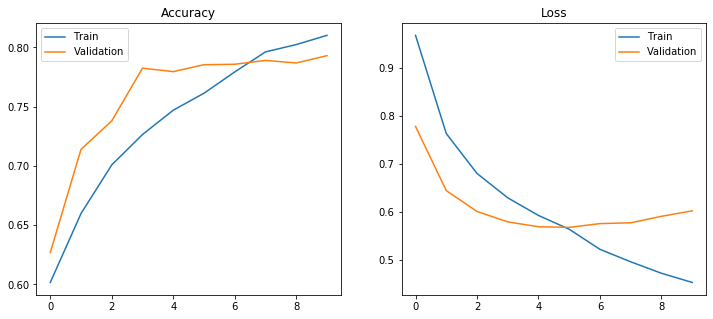

In [85]:
# Plot training history for the count vectorizer model.
def plotFitHistory(fitHistory):
    f, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(fitHistory.history['accuracy'], label='Train')
    ax[0].plot(fitHistory.history['val_accuracy'], label='Validation')
    ax[0].title.set_text("Accuracy")
    ax[0].legend()
    ax[1].plot(fitHistory.history['loss'], label='Train')
    ax[1].plot(fitHistory.history['val_loss'], label='Validation')
    ax[1].title.set_text("Loss")
    ax[1].legend()
    
plotFitHistory(history_cv)

In [86]:
# Get test loss and accuracy for each dataset.
train_loss_cv, train_accuracy_cv = model_cv.evaluate(X_train_cv, y_train_cv, verbose=0)
val_loss_cv, val_accuracy_cv = model_cv.evaluate(X_val_cv, y_val_cv, verbose=0)
test_loss_cv, test_accuracy_cv = model_cv.evaluate(X_test_cv, y_test_cv, verbose=0)
print("Train Accuracy:\t\t{:.4f}".format(train_accuracy_cv))
print("Train Loss:\t\t{:.4f}".format(train_loss_cv))
print("Validation Accuracy:\t{:.4f}".format(val_accuracy_cv))
print("Validation Loss:\t{:.4f}".format(val_loss_cv))
print("Test Accuracy:\t\t{:.4f}".format(test_accuracy_cv))
print("Test Loss:\t\t{:.4f}".format(test_loss_cv))

Train Accuracy:		0.9241
Train Loss:		0.2696
Validation Accuracy:	0.7931
Validation Loss:	0.6016
Test Accuracy:		0.7730
Test Loss:		0.6313


In [87]:
# Predict the sentiments of the test data.
y_test_cv_pred = model_cv.predict_classes(X_test_cv)

In [88]:
# Convert the actual test sentiments from onehot encoded to indices.
y_test_cv_ind = np.argmax(y_test_cv, axis=1)
print(y_test_cv_ind[0:5])

[2 1 2 0 2]


In [89]:
# Get the classification report for the countVectorizer model.
print("Count Vectorizer Classification Report")
print(classification_report(y_test_cv_ind, y_test_cv_pred))

Count Vectorizer Classification Report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      2294
           1       0.60      0.48      0.53       775
           2       0.73      0.68      0.70       591

    accuracy                           0.77      3660
   macro avg       0.72      0.68      0.70      3660
weighted avg       0.76      0.77      0.76      3660



Text(0.5, 15.0, 'Predicted')

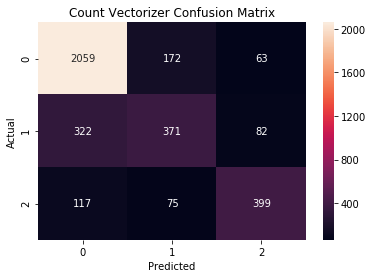

In [90]:
cm_cv=confusion_matrix(y_test_cv_ind, y_test_cv_pred)
sns.heatmap(cm_cv, annot=True,  fmt='g', xticklabels = [0,1,2] , yticklabels = [0,1,2] )
plt.title("Count Vectorizer Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [91]:
# Create a dataframe for comparison.
comparison_df = pd.DataFrame(columns=['Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

In [92]:
# Add the accuracies of the count vectorizer model to the comparison dataframe.
metricsDict = { 'Train Accuracy':train_accuracy_cv,
                'Validation Accuracy':val_accuracy_cv,
                'Test Accuracy':test_accuracy_cv}
metricsSeries = pd.Series(name='Count Vectorizer Model',data=metricsDict)
comparison_df = comparison_df.append(metricsSeries)

In [93]:
comparison_df

,Train Accuracy,Validation Accuracy,Test Accuracy
Count Vectorizer Model,0.9241,0.7931,0.7730


#### TF-IDF Data Preparation

In [94]:
# Create an array from the countVector.
tfidfVector_array = tfidfVector.toarray()

In [95]:
# Split the data into train and test sets.
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidfVector_array, sentiments_array, test_size=0.25, random_state=1, stratify=sentiments_array)

In [96]:
# Split the training data into train and validation sets.
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(X_train_tf, y_train_tf, test_size=0.25, random_state=1, stratify=y_train_tf)

In [97]:
# Print the shapes of all the data to make sure it is suitable.
print("X_train shape:\t" + str(X_train_tf.shape))
print("y_train shape:\t" + str(y_train_tf.shape))
print("X_val shape:\t" + str(X_val_tf.shape))
print("y_val shape:\t" + str(y_val_tf.shape))
print("X_test shape:\t" + str(X_test_tf.shape))
print("y_test shape:\t" + str(y_test_tf.shape))

X_train shape:	(8235, 5000)
y_train shape:	(8235, 3)
X_val shape:	(2745, 5000)
y_val shape:	(2745, 3)
X_test shape:	(3660, 5000)
y_test shape:	(3660, 3)


In [98]:
# Confirm that the datatypes of the X arrays are floats.
print("X_train datatype:\t" + str(X_train_tf[0,0].dtype))
print("X_val datatype:\t\t" + str(X_val_tf[0,0].dtype))
print("X_test datatype:\t" + str(X_test_tf[0,0].dtype))

X_train datatype:	float64
X_val datatype:		float64
X_test datatype:	float64


In [99]:
# Confirm that X array values are between 0 and 1.
print("X_train min and max:\t" + str(X_train_tf.min()) + " " + str(X_train_tf.max()))
print("X_val min and max:\t" + str(X_val_tf.min()) + " " + str(X_val_tf.max()))
print("X_test min and max:\t" + str(X_test_tf.min()) + " " + str(X_test_tf.max()))

X_train min and max:	0.0 1.0
X_val min and max:	0.0 1.0
X_test min and max:	0.0 1.0


#### TF-IDF Vectorizer Model

In [100]:
# Initialise the model.
model_tf = Sequential()
# Add the first hidden layer.
model_tf.add(Dense(16, input_shape=(X_train_tf.shape[1],), activation='relu'))
# Model was initially overfit, add dropout layer.
model_tf.add(Dropout(rate=0.5))
# Add a second hidden layer.
model_tf.add(Dense(8, activation='relu'))
# Add a drouput layer to reduce overfitting.
model_tf.add(Dropout(rate=0.5))
# Add the output layer.
model_tf.add(Dense(3, activation='softmax'))

In [101]:
# Compile the model.
model_tf.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [102]:
# View the model summary.
model_tf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                80016     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 80,179
Trainable params: 80,179
Non-trainable params: 0
_________________________________________________________________


In [103]:
# Train the model.
history_tf = model_tf.fit(X_train_tf, y_train_tf, validation_data=(X_val_tf, y_val_tf), batch_size=32, epochs=10, verbose=1)

Train on 8235 samples, validate on 2745 samples
Epoch 1/10
8235/8235 [==============================] - 2s 186us/sample - loss: 0.9136 - accuracy: 0.6255 - val_loss: 0.7786 - val_accuracy: 0.6270
Epoch 2/10
8235/8235 [==============================] - 1s 135us/sample - loss: 0.7506 - accuracy: 0.6500 - val_loss: 0.6780 - val_accuracy: 0.6863
Epoch 3/10
8235/8235 [==============================] - 1s 136us/sample - loss: 0.6628 - accuracy: 0.6975 - val_loss: 0.6364 - val_accuracy: 0.7650
Epoch 4/10
8235/8235 [==============================] - 1s 135us/sample - loss: 0.6137 - accuracy: 0.7109 - val_loss: 0.6240 - val_accuracy: 0.7577
Epoch 5/10
8235/8235 [==============================] - 1s 134us/sample - loss: 0.5806 - accuracy: 0.7276 - val_loss: 0.6210 - val_accuracy: 0.7679
Epoch 6/10
8235/8235 [==============================] - 1s 132us/sample - loss: 0.5413 - accuracy: 0.7479 - val_loss: 0.6310 - val_accuracy: 0.7672
Epoch 7/10
8235/8235 [==============================] - 1s 136us

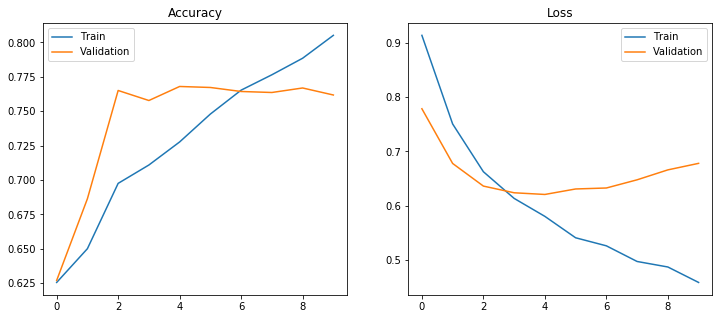

In [104]:
# Plot training history for the count vectorizer model.
def plotFitHistory(fitHistory):
    f, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(fitHistory.history['accuracy'], label='Train')
    ax[0].plot(fitHistory.history['val_accuracy'], label='Validation')
    ax[0].title.set_text("Accuracy")
    ax[0].legend()
    ax[1].plot(fitHistory.history['loss'], label='Train')
    ax[1].plot(fitHistory.history['val_loss'], label='Validation')
    ax[1].title.set_text("Loss")
    ax[1].legend()
    
plotFitHistory(history_tf)

In [105]:
# Get test loss and accuracy.
train_loss_tf, train_accuracy_tf = model_tf.evaluate(X_train_tf, y_train_tf, verbose=0)
val_loss_tf, val_accuracy_tf = model_tf.evaluate(X_val_tf, y_val_tf, verbose=0)
test_loss_tf, test_accuracy_tf = model_tf.evaluate(X_test_tf, y_test_tf, verbose=0)
print("Train Accuracy:\t{:.4f}".format(train_accuracy_tf))
print("Train Loss:\t{:.4f}".format(train_loss_tf))
print("Val Accuracy:\t{:.4f}".format(val_accuracy_tf))
print("Val Loss:\t{:.4f}".format(val_loss_tf))
print("Test Accuracy:\t{:.4f}".format(test_accuracy_tf))
print("Test Loss:\t{:.4f}".format(test_loss_tf))

Train Accuracy:	0.9208
Train Loss:	0.3249
Val Accuracy:	0.7617
Val Loss:	0.6782
Test Accuracy:	0.7667
Test Loss:	0.6362


In [106]:
# Predict the sentiments of the test data.
y_test_tf_pred = model_tf.predict_classes(X_test_tf)

In [107]:
# Convert the actual test sentiments from onehot encoded to indices.
y_test_tf_ind = np.argmax(y_test_tf, axis=1)
print(y_test_tf_ind[0:5])

[0 0 0 0 0]


In [108]:
# Get the classification report for the countVectorizer model.
print("TF-IDF Vectorizer Classification Report")
print(classification_report(y_test_tf_ind, y_test_tf_pred))

TF-IDF Vectorizer Classification Report
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      2294
           1       0.54      0.54      0.54       775
           2       0.75      0.61      0.67       591

    accuracy                           0.77      3660
   macro avg       0.71      0.68      0.69      3660
weighted avg       0.76      0.77      0.76      3660



Text(0.5, 15.0, 'Predicted')

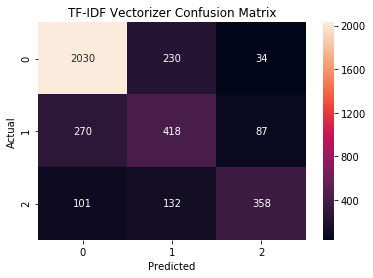

In [109]:
cm_tf=confusion_matrix(y_test_tf_ind, y_test_tf_pred)
sns.heatmap(cm_tf, annot=True,  fmt='g', xticklabels = [0,1,2] , yticklabels = [0,1,2] )
plt.title("TF-IDF Vectorizer Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [110]:
# Add the accuracies of the count vectorizer model to the comparison dataframe.
metricsDict = { 'Train Accuracy':train_accuracy_tf,
                'Validation Accuracy':val_accuracy_tf,
                'Test Accuracy':test_accuracy_tf}
metricsSeries = pd.Series(name='TF-IDF Vectorizer Model',data=metricsDict)
comparison_df = comparison_df.append(metricsSeries)

In [111]:
comparison_df

,Train Accuracy,Validation Accuracy,Test Accuracy
Count Vectorizer Model,0.9241,0.7931,0.7730
TF-IDF Vectorizer Model,0.9208,0.7617,0.7667


### 6. Summary

#### Results Summary

In [112]:
comparison_df

,Train Accuracy,Validation Accuracy,Test Accuracy
Count Vectorizer Model,0.9241,0.7931,0.7730
TF-IDF Vectorizer Model,0.9208,0.7617,0.7667


- The Count vectorizer and TF-IDF vectorizer yield similar results.
- The Count vectorizer is slightly more accurate for the current analysis.
- This is strange since TF-IDF is usually considered the better method.
- Maybe TF-IDF is better suited to few documents with high word counts, whereas our data contains many documents with low word counts.

#### Conclusion
I would not consider this model adequite for deployment in a business environment.
The text preprocessing needs to be improved. Some techniques more specific to twitter text data need developed.

#### Notes on Text Pre-Processing

Various pre-processing techniques were performed, herewith is a list of the techniques and the reason for using them:
- HTML tag removal: HTML tags are merely for web page formatting and hold no sentiment infromation. Therefore, they can be removed without consequence.
- Tokenization: Tokenization is required to perform other preprocessing techniques such as stop word removal and lemmatization.
- Removal of numbers: Numbers convey no sentiment information and can thus be removed with no consequence.
- Removal of special characters and punctuation: These carry no sentiment information and can be removed with no consequence.
- Conversion to lowercase: Case differences in words which are the same are seen as different words. Therefore, converting all words to lowercase ensures that all words that are the same are correctly identified.
- Splitting of hashtags: Hashtags usually combine many words into one word. This often forms a unique words which is found in only one text entry. Splitting the hashtag into the actual dictionary words helps with correct identification of words which can then be matched with words in other text entries. This enables the model to better learn the sentiment of the word.
- Converting emojis to words: Converting emojis to words can help to better idntify the sentiment of the emoji by being able to match the word which describes the emoji with words from other text entries and thus learning the sentiment of the word.

#### Notes on the Text Data

The twitter text data is particularly difficult to prepare for natural language processing.
This is because it is a social media platform and thus subject to very informal writing.
Informal writing attributes which makes text hard to process are:
- Hashtags: Hashtags convey important sentiment infromation, but they often string together multiple words which are hard to seperate correctly. If left unseperated, many tags will form unique words that are only present in a single entry.
- Slang and shorthand: A lot of slang and shorthand writing is unique to the user. Some slang and shorthand words then only form unique words which are only present in a single entry.
- Abbreviations: Abbreviations also convey sentiment information, but often also seem like gibberish and are difficult to expand into real words. However, a model will learn the sentiment of commonly used abbreviations.
- Emojis: Emojis convey good sentiment information, but are once again difficult to turn into actual words.
- Irregular use of spacing and punctuation: This causes words to be incorrectly tokenized many times, therefore forming new unique words which are not matched with words from other entries, yet would have conveyed the same sentiment information.

The fact that so many new and unqiue words are created from twitter data makes it difficult to train models. Models seem to become overfit very easily and yield low testing accuracy.
Improved text preprocessing is most likely the key to better model performance, some suggested techniques are:
- To keep a dictionary of common abbreviations and then to replace such abbreviations with a single word or a few words which match the sentiment of the abbreviation.
- To group emojis into categories, each category can then be represented by a word which most accurately conveys the sentiment of the group. Replace emojis with the category word.
- A dictionary of abbreviations can also be used to replace abbreviations with a single word or few words which convey the sentiment of the abbreviation. This would help mostly for less commonly used abbreviations.
- Keeping a dictionary of slang and shorthand and replacing such tokens with the real word. Although a model will learn the sentiment of slang and shorthand if they are used often, replaceing all shorthand variants of a word with the same word will result in more occurances of the actual word and thus better learning of the model. Slang can also be replaced with synonyms to result in higher word frequency.

